In [144]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import plotly.graph_objects as go
import ruptures as rpt
from itertools import combinations as comb
from statsmodels.stats import power
import numpy as np
from scipy import stats
from scipy.signal import find_peaks


import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import cdist
import colorsys

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
folder_path = 'data'
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    accelerometer['Time (s)'] = pd.to_datetime(accelerometer['Time (s)'], unit='s')
    accelerometer =accelerometer.set_index('Time (s)')
    accelerometer = accelerometer.resample('2.5ms').mean()
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    accelerometer =accelerometer[9000:-9000]
    accelerometer.reset_index(inplace=True)

    """
    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    gyroscope['Time (s)'] = pd.to_datetime(gyroscope['Time (s)'], unit='s')
    gyroscope =gyroscope.set_index('Time (s)')
    gyroscope = gyroscope.resample('2.5ms').mean()
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    gyroscope = gyroscope[9000:-9000]
    gyroscope.reset_index(inplace=True)
    merged = pd.merge(accelerometer,gyroscope, on= 'Time (s)', how='inner')
    return merged
    """
    return accelerometer

In [3]:
# regex to delete the number at the end of the string:
def delete_number(string):
    return ''.join([i for i in string if not i.isdigit()])

In [109]:
data_dict = {}
name_to_idx = {} # name -> idx
i = 0

for name in os.listdir(folder_path):
    data_dict[name] = read_data(name)
    data_dict[name].set_index('Time (s)', inplace=True)
    data_dict[name].interpolate(inplace=True, method="time")

    # add label
    if delete_number(name) not in name_to_idx.keys():
        name_to_idx[delete_number(name)] = i
        i+=1

In [112]:
def add_feature(axis_list, axis, X_train, appendix=""):
    #mean
    X_train[axis+'_mean'+appendix] = pd.Series(axis_list).apply(lambda x: x.mean())
    #std dev
    X_train[axis+'_std'+appendix] = pd.Series(axis_list).apply(lambda x: x.std())
    #avg absolute difference
    X_train[axis+'_aad'+appendix] = pd.Series(axis_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    #min
    X_train[axis+'_min'+appendix] = pd.Series(axis_list).apply(lambda x: x.min())
    #max
    X_train[axis+'_max'+appendix] = pd.Series(axis_list).apply(lambda x: x.max())
    #max-min diff
    X_train[axis+'_maxmin_diff'+appendix] = X_train[axis+'_max'+appendix] - X_train[axis+'_min'+appendix]
    #median
    X_train[axis+'_median'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(x))
    #median absolut deviation
    X_train[axis+'_mad'+appendix] = pd.Series(axis_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    #interquartile range
    X_train[axis+'_IQR'+appendix] = pd.Series(axis_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    if appendix != "_fft":
        #negative count
        X_train[axis+'_neg_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x < 0))
        #positive count
        X_train[axis+'_pos_count'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > 0))
    
    #values above mean
    X_train[axis+'_above_mean'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x > x.mean()))
    #number of peaks
    X_train[axis+'_peak_count'+appendix] = pd.Series(axis_list).apply(lambda x: len(find_peaks(x)[0]))
    #skewness
    X_train[axis+'_skewness'+appendix] = pd.Series(axis_list).apply(lambda x: stats.skew(x))
    #kurtosis
    X_train[axis+'_kurtosis'+appendix] = pd.Series(axis_list).apply(lambda x: stats.kurtosis(x))
    # energy
    X_train[axis+'_energy'+appendix] = pd.Series(axis_list).apply(lambda x: np.sum(x**2)/100)

    return X_train

In [113]:
verification_keys = ["nick2", "till2", "uta2", "paula2"]

In [114]:
name_to_idx

{'chris': 0,
 'felix': 1,
 'katarina': 2,
 'lucas': 3,
 'luisa': 4,
 'nele': 5,
 'nick': 6,
 'paula': 7,
 'till': 8,
 'uta': 9}

In [116]:
x_list = []
y_list = []
z_list = []
train_labels = []
x_test_list = []
y_test_list = []
z_test_list = []
test_labels = []
x_ver_list = []
y_ver_list = []
z_ver_list = []
ver_labels = []

window_size = 400
step_size = 200

# creating overlaping windows of size window-size 100
for name, df_train in data_dict.items():
    label = name_to_idx[delete_number(name)]
    if name in verification_keys:
        for i in range(0, df_train.shape[0] - window_size, step_size):
            xs = df_train['accelerometer_x'].values[i: i + window_size]
            ys = df_train['accelerometer_y'].values[i: i + window_size]
            zs = df_train['accelerometer_z'].values[i: i + window_size]
            x_ver_list.append(xs)
            y_ver_list.append(ys)
            z_ver_list.append(zs)
            ver_labels.append(label)

    else:
        for i in range(0, int(df_train.shape[0]*0.8) - window_size, step_size):
            xs = df_train['accelerometer_x'].values[i: i + window_size]
            ys = df_train['accelerometer_y'].values[i: i + window_size]
            zs = df_train['accelerometer_z'].values[i: i + window_size]
            #label = stats.mode(df_train['label'][i: i + window_size])[0][0]
        
            x_list.append(xs)
            y_list.append(ys)
            z_list.append(zs)
            train_labels.append(label)
    
        for i in range(int(df_train.shape[0]*0.8), df_train.shape[0] - window_size, step_size):
            xs = df_train['accelerometer_x'].values[i: i + window_size]
            ys = df_train['accelerometer_y'].values[i: i + window_size]
            zs = df_train['accelerometer_z'].values[i: i + window_size]
            #label = stats.mode(df_train['label'][i: i + window_size])[0][0]
        
            x_test_list.append(xs)
            y_test_list.append(ys)
            z_test_list.append(zs)
            test_labels.append(label)


##     ##
# Train #
##     ##
X_train = pd.DataFrame()
X_train = add_feature(x_list, 'x', X_train)
X_train = add_feature(y_list, 'y', X_train)
X_train = add_feature(z_list, 'z', X_train)
# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]
# signal magnitude area
X_train['sma'] = pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))
#FFT
x_fft_list = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
y_fft_list = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
z_fft_list = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
X_train = add_feature(x_fft_list, 'x', X_train, "_fft")
X_train = add_feature(y_fft_list, 'y', X_train, "_fft")
X_train = add_feature(z_fft_list, 'z', X_train, "_fft")
# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_fft_list)**2 + pd.Series(y_fft_list)**2 + pd.Series(z_fft_list)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_fft_list).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_fft_list).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_fft_list).apply(lambda x: np.sum(abs(x)/50))

##    ##
# Test #
##    ##
X_test = pd.DataFrame()
X_test = add_feature(x_test_list, 'x', X_test)
X_test = add_feature(y_test_list, 'y', X_test)
X_test = add_feature(z_test_list, 'z', X_test)
# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_test_list)**2 + pd.Series(y_test_list)**2 + pd.Series(z_test_list)**2)**0.5)]
# signal magnitude area
X_test['sma'] = pd.Series(x_test_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_test_list).apply(lambda x: np.sum(abs(x)/100)) \
              + pd.Series(z_test_list).apply(lambda x: np.sum(abs(x)/100))
#FFT
x_test_fft_list = pd.Series(x_test_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
y_test_fft_list = pd.Series(y_test_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
z_test_fft_list = pd.Series(z_test_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
X_test = add_feature(x_test_fft_list, 'x', X_test, "_fft")
X_test = add_feature(y_test_fft_list, 'y', X_test, "_fft")
X_test = add_feature(z_test_fft_list, 'z', X_test, "_fft")
# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_test_fft_list)**2 + pd.Series(y_test_fft_list)**2 + pd.Series(z_test_fft_list)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_test_fft_list).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_test_fft_list).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_test_fft_list).apply(lambda x: np.sum(abs(x)/50))

##   ##
# Ver #
##   ##
X_ver = pd.DataFrame()
X_ver = add_feature(x_ver_list, 'x', X_ver)
X_ver = add_feature(y_ver_list, 'y', X_ver)
X_ver = add_feature(z_ver_list, 'z', X_ver)
# avg resultant
X_ver['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_ver_list)**2 + pd.Series(y_ver_list)**2 + pd.Series(z_ver_list)**2)**0.5)]
# signal magnitude area
X_ver['sma'] = pd.Series(x_ver_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_ver_list).apply(lambda x: np.sum(abs(x)/100)) \
             + pd.Series(z_ver_list).apply(lambda x: np.sum(abs(x)/100))
#FFT
x_ver_fft_list = pd.Series(x_ver_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
y_ver_fft_list = pd.Series(y_ver_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
z_ver_fft_list = pd.Series(z_ver_list).apply(lambda x: np.abs(np.fft.fft(x))[1:window_size//2+1])
X_ver = add_feature(x_ver_fft_list, 'x', X_ver, "_fft")
X_ver = add_feature(y_ver_fft_list, 'y', X_ver, "_fft")
X_ver = add_feature(z_ver_fft_list, 'z', X_ver, "_fft")
# FFT avg resultant
X_ver['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_ver_fft_list)**2 + pd.Series(y_ver_fft_list)**2 + pd.Series(z_ver_fft_list)**2)**0.5)]

# FFT Signal magnitude area
X_ver['sma_fft'] = pd.Series(x_ver_fft_list).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_ver_fft_list).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_ver_fft_list).apply(lambda x: np.sum(abs(x)/50))



In [117]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)
y_ver = np.array(ver_labels)

## XGBoost

In [118]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [119]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Accuracy: 0.95822454308094
X_train shape: (10770, 94)
X_test shape: (2681, 94)
y_train shape: (10770,)
y_test shape: (2681,)


In [120]:
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       332
           1       1.00      0.99      1.00       302
           2       0.92      1.00      0.96       184
           3       0.97      0.99      0.98       158
           4       1.00      0.99      0.99       254
           5       0.99      1.00      1.00       197
           6       0.89      0.99      0.94       688
           7       1.00      1.00      1.00        93
           8       1.00      0.98      0.99       265
           9       1.00      0.98      0.99       208

    accuracy                           0.96      2681
   macro avg       0.98      0.97      0.97      2681
weighted avg       0.96      0.96      0.96      2681



In [121]:
y_pred_proba.min(), y_pred_proba.max()

(6.3384346e-07, 0.9999882)

## Linear Regression

In [140]:
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9623274897426334

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       332
           1       0.99      0.96      0.97       302
           2       0.92      1.00      0.96       184
           3       0.99      1.00      1.00       158
           4       1.00      1.00      1.00       254
           5       0.99      1.00      1.00       197
           6       0.92      1.00      0.96       688
           7       0.98      0.99      0.98        93
           8       1.00      0.98      0.99       265
           9       1.00      0.98      0.99       208

    accuracy                           0.96      2681
   macro avg       0.97      0.97      0.97      2681
weighted avg       0.96      0.96      0.96      2681



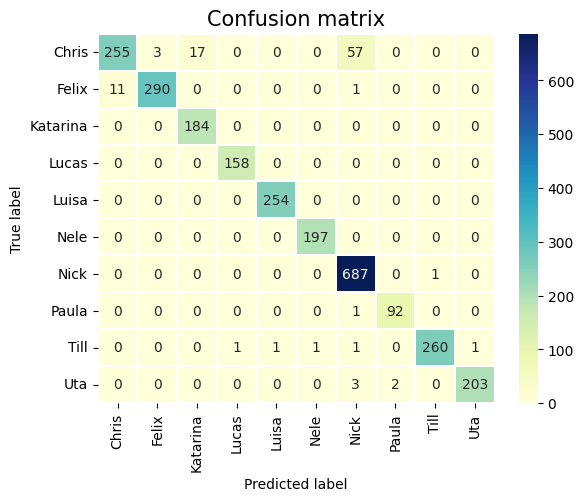

In [145]:
labels = ['Chris', 'Felix', 'Katarina', 'Lucas', 'Luisa', 'Nele', 'Nick', 'Paula', 'Till', 'Uta']
confusionMatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusionMatrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Verification with all second runs

In [146]:
y_pred_ver = model.predict(X_ver)
y_pred_proba_ver = model.predict_proba(X_ver)
accuracy = accuracy_score(y_pred_ver, y_ver)
accuracy

0.6096374889478338

In [147]:
report = classification_report(y_ver, y_pred_ver)

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.40      1.00      0.57      1049
           7       1.00      1.00      1.00       472
           8       0.97      0.97      0.97      1276
           9       1.00      0.00      0.00      1727

    accuracy                           0.61      4524
   macro avg       0.34      0.30      0.25      4524
weighted avg       0.85      0.61      0.51      4524

